In [1]:
import numpy as np
import random as rm
import pandas as pd
from random import seed
from random import random
import matplotlib.pyplot as plt
from pylab import *
from scipy.optimize import curve_fit
from scipy.stats import bernoulli, binom, norm
from scipy import integrate

In [2]:
# build the target distribution
mu1, sigma1 = 0, 0.5
mu2, sigma2 = 17.5, 1
# N = 500

# x1 = np.random.normal(mu1, sigma1, N)
# x2 = np.random.normal(mu2, sigma2, N)

# f_pi = (0.4*x1 + 0.6*x2)

In [3]:
mu_list = [0,17.5]
sigma_list = [.5,1]
alpha_list = [0.4,0.6]
p = 0.75
test = 2
n= 100

In [5]:
# Adam's version
def f_pi_1(x):
    prob_density = 0
    for i in range(len(mu_list)):
        prob_density += alpha_list[i]*norm.pdf(x,mu_list[i],sigma_list[i]**0.5)
    return prob_density

print(f_pi_1(1))
print(f_pi_1(2))
print(f_pi_1(3))

0.08302149948411897
0.004133397070818414
2.7850610389349622e-05


In [42]:
def simulate(mu_list, sigma_list, n, alpha_list,p):
    def f_pi(x):
        prob_density = 0
        for i in range(len(mu_list)):
            prob_density += alpha_list[i]*norm.pdf(x,mu_list[i],sigma_list[i]**0.5)
        return prob_density
    
    def f_eta(x):
        return f_pi(x)**p 
    
    constant = integrate.quad(f_eta,-np.inf,np.inf)[0]
    name = f_pi(1)
    et = f_eta(1)/constant
    return constant, name, et

In [43]:
# calculate the constant
c = (simulate(mu_list, sigma_list, n, alpha_list, p))
print(c)


(1.6606303582223592, 0.08302149948411897, 0.09313650928738189)


In [40]:
# Haoming's version
def f_eta_1(x):
    prob_density = 0
    for i in range(len(mu_list)):
        prob_density += alpha_list[i]*norm.pdf(x,mu_list[i],sigma_list[i]**0.5)
    prob_density = np.power(prob_density, p)
    return (prob_density/c)[0]

In [41]:
f_eta_1(1)

0.09313650928738189

## Method 1

In [65]:
# calculate constant c
f_pi = lambda x: 0.4*(1/np.sqrt(2*math.pi*sigma1))*np.exp((-1/2)*((x-mu1)**2/sigma1)) + 0.6*(1/np.sqrt(2*math.pi*sigma2))*np.exp((-1/2)*((x-mu2)**2/sigma2))
pdf_eta = lambda x: np.power(0.4*(1/np.sqrt(2*math.pi*sigma1))*np.exp((-1/2)*((x-mu1)**2/sigma1)) + 0.6*(1/np.sqrt(2*math.pi*sigma2))*np.exp((-1/2)*((x-mu2)**2/sigma2)),0.75)
c = integrate.quad(pdf_eta, -inf, inf)
c = c[0]

In [66]:
def pdf_eta(x):
    output = (f_pi(x))**0.75
    return(output)


In [67]:
# define eta
def f_eta(x):
    return(pdf_eta(x)/c)

#pdf_eta = lambda x: np.power(0.4*(1/np.sqrt(2*math.pi*sigma1))*np.exp((-1/2)*((x-mu1)**2/sigma1)) + 0.6*(1/np.sqrt(2*math.pi*sigma2))*np.exp((-1/2)*((x-mu2)**2/sigma2)),0.75)


In [47]:
# define g
def g(x):
    return(f_pi(x)/f_eta(x))

In [76]:
# P
def p_kernel(y0, sigma, n):
    count = 0
    Yn = y0
    estimator = [y0]
    while count<n:
        y = np.random.normal(Yn,sigma)
        u = np.random.uniform(0,1)
        alpha = min((f_eta(y)/f_eta(Yn)),1)
        if u <= alpha:
            estimator.append(y)
            Yn = y
            count +=1
    return estimator

In [77]:
# K
def k_kernel(x0, sigma):
    count = 0
    Xn = x0
    estimator = [x0]
    while count<1:
        y = np.random.normal(Xn, sigma)
        u = np.random.uniform(0,1)
        alpha = min((f_eta(y)/f_eta(Xn)),1)
        if u <= alpha:
            estimator.append(y)
            Xn = y
            count +=1
    return estimator[-1]

In [78]:
def S_y_new(n, sigma, y0):
    y = [y0]
    sumn = 0
    for i in range(n+1):
        y.append(p_kernel(y0,sigma,n))
    for k in y:
        sumn += g(k)
    return sumn

def sum_g_update(sum_old, yn):
    sum_new = sum_old + g(yn)
    return(sum_new)

def prob_list_new(y, sum_new):
    prob_list = []
    for i in y:
        prob_list.append(g(i)/sum_new)
    return prob_list

def bernoulli_list(epsilon, n):
    b_list = bernoulli(epsilon).rvs(n)
    return b_list

In [79]:
def prob_list(y):
    prob_list = []
    sum = 0
    for i in y:
        sum += g(i)
    for i in y:
        prob_list.append(g(i)/sum)
    return prob_list

def x_sample(x0, epsilon, y, n, sigma):
    X_list = [x0]
    bernoullis = bernoulli_list(epsilon, n)
    for k in range(1,n): # +1?
        i = bernoullis[k]
        if i == 0:
            X_list.append(k_kernel(x0, sigma))
        if i == 1:
            X_list.append(np.random.choice(y[:k], p = prob_list(y[:k])))
        x0 = X_list[-1]
    return X_list


In [72]:
# define epsilon
epsilon1 = 0.05
epsilon2 = 0.25
epsilon3 = 0.5
epsilon4 = 0.75
epsilon5 = 0.95

In [73]:
# expectation
def E_x(X_list):
    sum = 0
    for i in X_list:
        sum += i
    mean = sum/len(X_list)
    return mean

In [83]:
def x_sample_new(x0, epsilon, y0, n, sigma):
    X_list = [x0]
    Y_list = [y0]
    sum_gs = g(y0)
    Y_list = p_kernel(y0,sigma,n)
    for k in range(1, n):
        #YnPlusOne = p_kernel(Y_list[-1], sigma, 1)
        #print(YnPlusOne)
        #Y_list.append(YnPlusOne)
        sum_gs = sum_g_update(sum_gs, Y_list[k])
        #print(sum_gs)
        #print(Y_list[:k+1])
        prob_list_Ys = prob_list_new(Y_list[:k+1], sum_gs)
        bernoullis = bernoulli_list(epsilon, 1)
        i = bernoullis
        if i == 0:
            X_list.append(k_kernel(x0, sigma))
        if i == 1:
            X_list.append(np.random.choice(Y_list[:k+1], p = prob_list_Ys))
        x0 = X_list[-1]
        
    #x_bar = np.mean(X_list)*(1- 1/(n+1)) + 1/(n+1) * X_list[-1]
    #return x_bar
    #return [X_list, Y_list]
    return prob_list_Ys

In [85]:
x_sample_new(10, 0.25, 15, 10, 1)

[0.05318030090449081,
 0.11014917415171323,
 0.09794952080481614,
 0.11605645489315972,
 0.09811460131245406,
 0.10562410368264609,
 0.09681735572162395,
 0.1123648144205145,
 0.0991104244603305,
 0.1106332496482509]

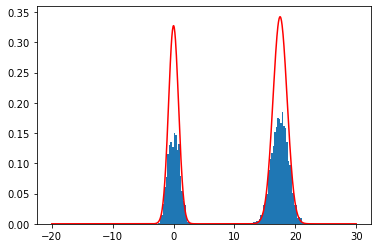

In [46]:
plt.hist(y, density = True, bins = 100)
t = np.linspace(-20,30,1000)
vals = pdf_eta(t)
plt.plot(t,vals, 'r')

In [53]:
x0 = 10
y0 = 15
n = 5000
y = p_kernel(y0, 10, n)
x_list = x_sample(x0, epsilon1, y, n, 2)
print(E_x(x_list))

plt.hist(x_list, bins = 100, density = True)
t = np.linspace(-10,30,1000)
vals = f_pi(t)
plt.plot(t,vals, 'r')

TypeError: unsupported operand type(s) for -: 'list' and 'int'

In [48]:
x0 = 10
y0 = 15
n = 3
y = p_kernel(y0, 10, n)
mean = x_sample_new(x0, epsilon2, y0, n, 2)
print(mean)

[[10, 17.25365090894364, 18.14074011576832], [15, 17.25365090894364, 16.491922277579192, 16.16979774530909]]


(array([  2.,   0.,   0.,   3.,  31., 116., 169., 119.,  51.,   9.]),
 array([10.        , 11.13379174, 12.26758348, 13.40137521, 14.53516695,
        15.66895869, 16.80275043, 17.93654217, 19.07033391, 20.20412564,
        21.33791738]),
 <BarContainer object of 10 artists>)

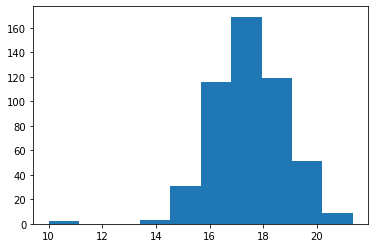

In [51]:
x0 = 10
y0 = 15
n = 500
y = p_kernel(y0, 10, n)
mean = x_sample_new(x0, epsilon1, y0, n, 4)
plt.hist(mean[0])

[15, -1.8140181674137992, -0.5606931549356213, 1.2534241356644031, 15.941329373130278, -0.8087291199752169, 19.265888481501285, 18.79212304943626, 16.06686353096225, 19.251418070036273, 0.6802383672480303, 0.9391035758848022, -0.4456963163208677, 1.6325949473173953, 2.2516075123655384, 2.378086685463055, 16.067663937978438, 0.29672553549228375, -0.41508517613952844, -1.3437333502446651, 1.0121040037109643, 1.52975680232852, 16.868425205094677, 19.175917546437525, 18.2921438799233, -0.46274578682812617, 0.4666069145631131, 0.3934175519788531, 0.3082998651115756, 0.09867499571052396, 0.040953080439894776, 0.05241996887329349, 18.721114129896563, 16.00902625458054, 17.200446866515804, 18.1651307083427, 18.418382879324202, 17.880869504326807, 18.068705229348513, 16.075320628788248, 15.28108200952698, 19.39092895902138, 14.985953784922552, 22.008108904115076, 19.6427875344704, 19.535890481684785, 17.5297719872917, 20.54382688655521, 19.671191259855707, 19.338493846289946, 17.385236866558735

(array([14.,  8.,  0.,  0.,  0.,  0.,  0., 10., 15.,  4.]),
 array([-1.81401817,  0.56819454,  2.95040725,  5.33261995,  7.71483266,
        10.09704537, 12.47925808, 14.86147078, 17.24368349, 19.6258962 ,
        22.0081089 ]),
 <BarContainer object of 10 artists>)

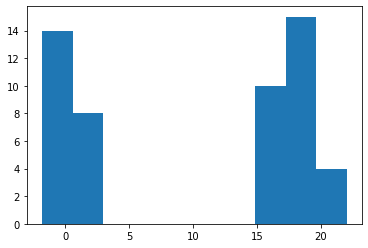

In [52]:
ytest = p_kernel(15, 10, 50)
print(ytest)
plt.hist(ytest)